# Université Paul Sabatier
# M1 IAFA - Foundations of Information Retrieval - 2025

Instructors: Lynda Tamine and Jesús Lovón

---

💡 Consider developing auxiliary scripts and functions that will enable you to reuse recurring commands in this practical work (PW) and future ones. This would help you keeping good code practice and make debugging easier.


### Attention❗ About TP grading:
🚨 *Code questions*: Fill in the missing code in the corresponding sections (commented code gets the best marks).

🚨 *Open questions*: Write your textual answer as a comment in the corresponding cells.

🚨 *Keep your outputs*: **Empty outputs (notebook or non-executed cells) correspond to 0 points**.

---

# TP 2: Traditional Information Retrieval with PyTerrier

## Inverted Indexing and Evaluation

Information Retrieval (IR) systems are essential for processing and retrieving relevant information from **large collections of text**. In this PW, we will build on concepts introduced in the previous lab work to construct an **inverted index**, execute **queries**, and evaluate **retrieval models** using PyTerrier (Terrier Python version).


### Objectives


Through this PW, you will:

1. Build an inverted index for a given document corpus.
2. Perform queries using term-weighting methods.
3. Evaluate different retrieval models using standard IR metrics.
4. Design experimental pipelines to compare retrieval models.

This lab extends the toy indexing system from the previous session to work with a **larger dataset** and introduces a structured evaluation framework to assess retrieval performance.

## Installations and Setup

Installing a framework like Terrier or PyTerrier can be complicated. However, its creators have decided to simplify many of the installation tasks. To this end, we will perform a simple installation using pip on Python.

PyTerrier automates many of the indexing and retrieval processes, making it easy to experiment with different configurations.

> 👉 This PW only requires a *CPU runtime*.

In [ ]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
!export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64

In [ ]:
# Some libraries to use later
!pip install python-terrier
!pip install scikit-learn matplotlib
!pip install datasets

In [ ]:
#Initialization de JVM
import pyterrier as pt
if not pt.started():
  pt.init(tqdm='notebook')

<ipython-input-28-de0af04feaa9>:3: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


# I. Indexing

Indexing is a crucial step in IR, as it allows the system to efficiently store and retrieve documents.




## 1. Collecting the Document Corpus
*(Refer to slides 15 and 16 for theoretical concepts)*

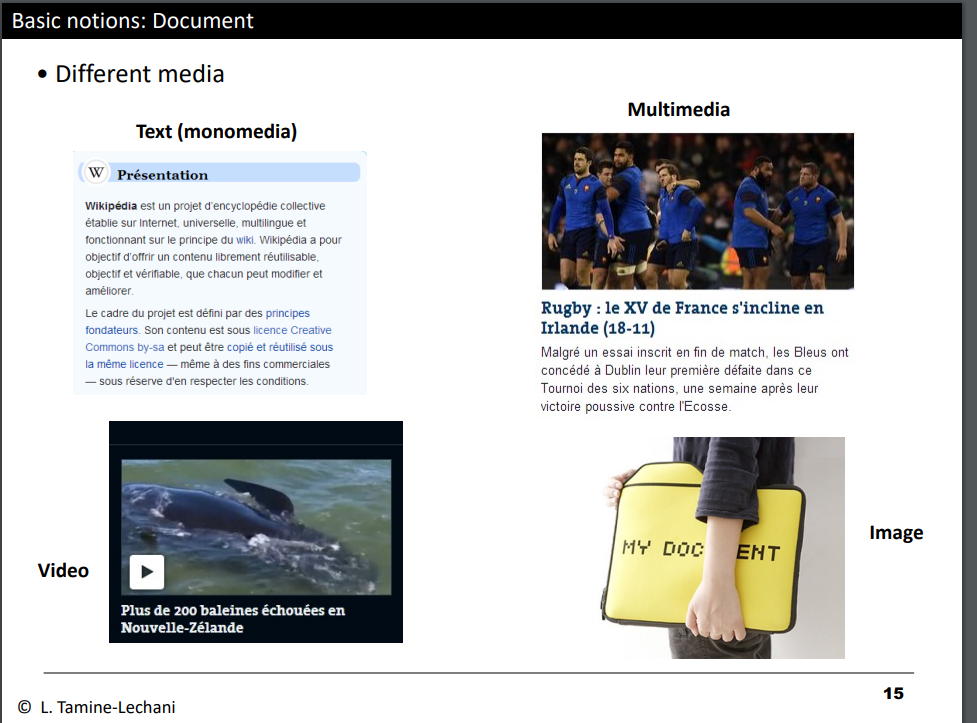

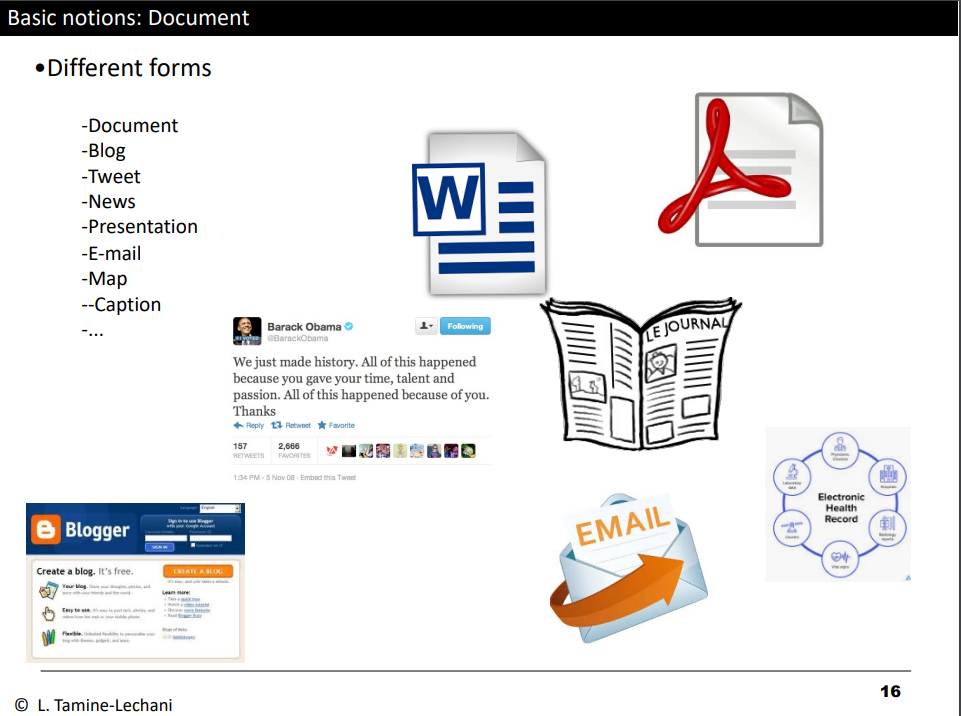

There are corpora of text documents available for free download hosted on [Datasets from HuggingFaces](https://huggingface.co/docs/datasets/index) and [Pyterrier](https://pyterrier.readthedocs.io/en/latest/datasets.html#available-datasets)

In the previous PW, we used a toy version of the *CORD19* dataset. Here, we will work with the *full* version.

We can gather the data with the following lines:


In [ ]:
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = dataset.get_topics(variant='description')

## 2. Building an Inverted Index
**(Refer to class material for details.)**

In the previous PW, each document was stored as an independent variable or representation. However, this approach is inefficient for large-scale search tasks. Instead, an **inverted index** allows us to:
- Reduce computational costs for large-scale search.
- Enable efficient document retrieval through structured term-document mapping.


Let's start by printing a sample entry of the dataset. As you can see, each entry is in JSON format with different information fields.

In [ ]:
next(iter(dataset.get_corpus_iter()))

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

{'title': 'Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia',
 'doi': '10.1186/1471-2334-1-6',
 'date': '2001-07-04',
 'abstract': 'OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) h

We now proceed to index the complete dataset (code below)

The task seems trivial, but the PyTerrier framework does most of the work. For more details, on how to create an index and the parameters to use, refer to the [documentation](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html).

In [ ]:
# Index the collection
!rm -rf ./terrier_cord19/

pt_index_path = './terrier_cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
    # create the index, using the IterDictIndexer indexer
    indexer = pt.index.IterDictIndexer(pt_index_path, text_attrs=['abstract'], meta=['title','docno'])

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    # index_ref = indexer.index(cord19.get_corpus_iter(),
    #                           text_attrs=['abstract'])
    indexref = indexer.index(dataset.get_corpus_iter(), )

else:
    # if you already have the index, use it.
    indexref = pt.IndexRef.of(pt_index_path + "/data.properties")

index = pt.IndexFactory.of(indexref)

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

19:48:30.872 [ForkJoinPool-4-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
19:49:49.091 [ForkJoinPool-4-worker-3] ERROR org.terrier.structures.indexing.Indexer -- Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.indexDocuments(BasicIndexer.java:270)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:388)
	at org.terrier.structures.indexing.Indexer.index(In

From the given code, we can notice that the most important line is
> indexer = pt.index.IterDictIndexer(pt_index_path, text_attrs=['abstract'], meta=['title','docno'])

Where:
- `text_attrs=['abstract']`: Defines the content used for indexing and search.
- `meta=['title','docno']`: Specifies additional metadata stored in the index.


📌 Note that the `./terrier_cord19` folder will be created to store the index. Ensure you save it if you need persistent storage.




####  Question ✍
1. What are the statistics of the created index? (refer to the documentation to answer)

In [ ]:
print(index.getCollectionStatistics().toString())


Number of documents: 192509
Number of terms: 151235
Number of postings: 11554033
Number of fields: 0
Number of tokens: 17728468
Field names: []
Positions:   false



####  Question ✍
2. List the files inside `terrier_cord19`.
  - Use the function `getLexicon()` from the index to print the vocabulary and the function `getValue().toString()` to print the content of each word in our vocabulary. Print only 20 words to simplify the output.
  - What is the meaning of `Nt`, `TF` and `maxTF`? (refer to class material if needed)

In [ ]:
#### Your code here
# Lister les fichiers de l'index
!ls terrier_cord19

# Charger l'index
index = pt.IndexFactory.of("./terrier_cord19/data.properties")

# Récupérer le lexique (vocabulaire)
lexicon = index.getLexicon()

# Afficher 20 termes et leurs valeurs associées
count = 0
for entry in lexicon:
    print(entry.getKey(), ":", entry.getValue().toString())  # Mot et ses détails
    count += 1
    if count == 20:  # Arrêter après 20 mots
        break



data.direct.bf		   data.meta-0.fsomapfile.-1  data.meta-0.fsomapfile.7
data.document.fsarrayfile  data.meta-0.fsomapfile.1   data.meta-0.fsomapfile.8
data.inverted.bf	   data.meta-0.fsomapfile.2   data.meta-0.fsomapfile.9
data.lexicon.fsomapfile    data.meta-0.fsomapfile.3   data.meta.idx
data.lexicon.fsomaphash    data.meta-0.fsomapfile.4   data.meta.zdata
data.lexicon.fsomapid	   data.meta-0.fsomapfile.5   data.properties
data.meta-0.fsomapfile.0   data.meta-0.fsomapfile.6
0 : term23 Nt=27012 TF=103854 maxTF=2147483647 @{0 0 0}
00 : term3624 Nt=1046 TF=1577 maxTF=2147483647 @{0 28173 6}
000 : term1007 Nt=4054 TF=6391 maxTF=2147483647 @{0 30007 3}
0001 : term4184 Nt=1557 TF=2560 maxTF=2147483647 @{0 35483 0}
0002 : term12960 Nt=138 TF=150 maxTF=2147483647 @{0 38028 1}
0003 : term7586 Nt=101 TF=108 maxTF=2147483647 @{0 38353 7}
0004 : term7055 Nt=92 TF=97 maxTF=2147483647 @{0 38602 0}
0005 : term8102 Nt=111 TF=142 maxTF=2147483647 @{0 38836 3}
0006 : term28238 Nt=57 TF=64 maxTF=2147483

####  Question ✍

3. You might notice that `getLexicon()` returns a Dictionary where the key is the stored word. The code below provides a pointer to the word `vaccine` in our index.

Iterate the different postings list for this word using the line `getInvertedIndex().getPostings(pointer)`. Print the `ID`, `TF`, and `doclen` for each document, and provide the meaning of these elements.

In [ ]:
pointer = index.getLexicon()["vaccine"]
pointer.toString()

'term7406 Nt=38 TF=52 maxTF=2147483647 @{0 15467742 2}'

In [ ]:
postings = index.getInvertedIndex().getPostings(pointer)

for posting in postings:
    doc_id = posting.getId()  # Récupère l'ID du document
    term_freq = posting.getFrequency()  # Nombre d'occurrences du mot "vaccine" dans ce doc
    doc_length = posting.getDocumentLength()  # Nombre total de mots dans le document

    print(f"Doc ID: {doc_id} | TF: {term_freq} | doclen: {doc_length}")

Doc ID: 579 | TF: 1 | doclen: 198
Doc ID: 965 | TF: 1 | doclen: 189
Doc ID: 1710 | TF: 1 | doclen: 145
Doc ID: 2153 | TF: 1 | doclen: 218
Doc ID: 2226 | TF: 1 | doclen: 178
Doc ID: 2522 | TF: 1 | doclen: 154
Doc ID: 4629 | TF: 1 | doclen: 299
Doc ID: 4903 | TF: 7 | doclen: 251
Doc ID: 6884 | TF: 1 | doclen: 108
Doc ID: 7490 | TF: 1 | doclen: 121
Doc ID: 7521 | TF: 1 | doclen: 106
Doc ID: 11685 | TF: 1 | doclen: 136
Doc ID: 12613 | TF: 1 | doclen: 164
Doc ID: 13338 | TF: 1 | doclen: 230
Doc ID: 21242 | TF: 1 | doclen: 236
Doc ID: 31814 | TF: 1 | doclen: 246
Doc ID: 48699 | TF: 1 | doclen: 118
Doc ID: 50786 | TF: 1 | doclen: 212
Doc ID: 63003 | TF: 2 | doclen: 72
Doc ID: 70390 | TF: 1 | doclen: 110
Doc ID: 84467 | TF: 5 | doclen: 158
Doc ID: 134389 | TF: 1 | doclen: 170
Doc ID: 134910 | TF: 1 | doclen: 122
Doc ID: 136727 | TF: 1 | doclen: 77
Doc ID: 141767 | TF: 1 | doclen: 183
Doc ID: 143083 | TF: 1 | doclen: 260
Doc ID: 144498 | TF: 1 | doclen: 89
Doc ID: 145001 | TF: 2 | doclen: 172
D

# II. Querying and Retrieval Models

Now that we have an index, we can perform search queries and retrieve relevant documents using the BatchRetrieve object from PyTerrier.

For our example, we will use the `TF-IDF` retrieval model (code below), specified in the `wmodel` param.

> Notice that the output is in DataFrame format.

In [ ]:
pt.BatchRetrieve(index, wmodel="TF_IDF").search("vaccine")

<ipython-input-36-dcf49436c7fb>:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  pt.BatchRetrieve(index, wmodel="TF_IDF").search("vaccine")


,qid,docid,docno,rank,score,query
0,1,29970,jwd96s79,0,4.785799,vaccine
1,1,82260,91rm1uvs,1,4.749890,vaccine
2,1,51059,xhe9nuvt,2,4.726156,vaccine
3,1,175627,4xkux5z4,3,4.715711,vaccine
4,1,134087,j93f6eso,4,4.698982,vaccine
...,...,...,...,...,...,...
995,1,7668,5hifn0cf,995,4.170605,vaccine
996,1,11567,t3eeks1n,996,4.170605,vaccine
997,1,16687,i2a6nix7,997,4.170605,vaccine
998,1,87694,7ykbbax6,998,4.170605,vaccine


Also, we can specify `metadata=["docno", "title"]` to display relevant fields in results.

In [ ]:
pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno","title"]).search("vaccine")

<ipython-input-37-f6a573b8d6d2>:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno","title"]).search("vaccine")


,qid,docid,docno,title,rank,score,query
0,1,29970,jwd96s79,Combined infectious bronchitis virus Arkansas ...,0,4.785799,vaccine
1,1,82260,91rm1uvs,Efficacy of two canine parvovirus vaccines for...,1,4.749890,vaccine
2,1,51059,xhe9nuvt,Efficacy of intradermally administrated E2 sub...,2,4.726156,vaccine
3,1,175627,4xkux5z4,Recent Advances in Vaccine Technologies,3,4.715711,vaccine
4,1,134087,j93f6eso,What influenza vaccination programmes are pref...,4,4.698982,vaccine
...,...,...,...,...,...,...,...
995,1,7668,5hifn0cf,Population implications of the deployment of n...,995,4.170605,vaccine
996,1,11567,t3eeks1n,Vaccination against the Epstein–Barr virus,996,4.170605,vaccine
997,1,16687,i2a6nix7,Economic Implications of Influenza and Influen...,997,4.170605,vaccine
998,1,87694,7ykbbax6,Ii-Key/MHC class II epitope hybrids: a strateg...,998,4.170605,vaccine


Other models are available. They are described in [Pyterrier](https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html#terrier-configuration) or [Terrier](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html) including:


- BM25 (default probabilistic model)
- DFR BM25 (Divergence From Randomness BM25)
- BM11 and BM15 (variations of BM25)

####  Question ✍
4. Use the `DFR BM25` model to search with the query `vaccine` and only show the `docno` as metadata. Give the code and the output.

In [ ]:
#### Your code here
pt.BatchRetrieve(index, wmodel="DFR_BM25", metadata=["docno"]).search("vaccine")


<ipython-input-38-86817da7b2f7>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  pt.BatchRetrieve(index, wmodel="DFR_BM25", metadata=["docno"]).search("vaccine")


,qid,docid,docno,rank,score,query
0,1,29970,jwd96s79,0,3.840654,vaccine
1,1,82260,91rm1uvs,1,3.808980,vaccine
2,1,51059,xhe9nuvt,2,3.791953,vaccine
3,1,175627,4xkux5z4,3,3.776838,vaccine
4,1,134087,j93f6eso,4,3.771903,vaccine
...,...,...,...,...,...,...
995,1,16666,7l8roegq,995,3.349491,vaccine
996,1,174385,4ytphmji,996,3.349491,vaccine
997,1,14643,c3ha5cax,997,3.348956,vaccine
998,1,172416,3a9vjpvn,998,3.348718,vaccine


####  Question ✍
5. [Two variations of BM25 are BM11 and BM15](https://en.wikipedia.org/wiki/Okapi_BM25#Modifications). To calculate them, you only need to modify one parameter.

Below you'll find the calculation for BM11. Do the same for BM15.

In [ ]:
from heapq import nlargest

index = pt.IndexFactory.of(indexref)
inv = index.getInvertedIndex()
meta = index.getMetaIndex()
lex = index.getLexicon()
le = lex.getLexiconEntry( "franc" )

wmodel = pt.autoclass("org.terrier.matching.models.BM25")()
wmodel.setCollectionStatistics(index.getCollectionStatistics())
wmodel.setEntryStatistics(le);
wmodel.setKeyFrequency(1)
wmodel.prepare()

<ipython-input-39-d8f943a5537e>:9: DeprecationWarning: Call to deprecated function (or staticmethod) autoclass. (use pt.java.autoclass(...) instead) -- Deprecated since version 0.11.0.
  wmodel = pt.autoclass("org.terrier.matching.models.BM25")()


In [ ]:
#BM11
wmodel.setParameter(1)

for docno, url, title, score in nlargest(10, [(meta.getItem("docno", posting.getId()),meta.getItem("url", posting.getId()),meta.getItem("title", posting.getId()),wmodel.score(posting)) for posting in inv.getPostings(le)], key=lambda e:e[3]):
  print("%s %s %s with score %0.4f"  % (docno, url, title, score))

b5il5qvt  KI and WU Polyomaviruses in Children, France with score 15.7145
u34gjez1  Specific organization for in-hospital belatacept infusion to avoid nosocomial transmission during the SARS-CoV-2 pandemic with score 14.7239
80xdyhbp  Specific organization for in‐hospital belatacept infusion to avoid nosocomial transmission during the SARS‐CoV‐2 pandemic with score 14.7239
pxymyqoy  Influenza D Virus in Cattle, France, 2011–2014 with score 14.3137
vcvuvspj  Keys for analysis of diagnostic and serologic tests for CoV-2 with score 14.0017
p0kdii0l  Keys for analysis of diagnostic and serologic tests for CoV-2 with score 14.0017
y1nherse  Risque d’introduction et voies d’importation par l’homme de maladies infectieuses exotiques : cas particulier de l’émergence de bactéries pathogènes multirésistantes aux antibiotiques, importées en France à l’occasion de voyages internationaux ou du rapatriement de patients hospitalisés à l’étranger with score 13.7764
n6ff63co  Managing an obstetrics and

In [ ]:
#### Your code here
#BM15
wmodel.setParameter(0)  # BM15

for docno, url, title, score in nlargest(10, [(meta.getItem("docno", posting.getId()),
                                               meta.getItem("url", posting.getId()),
                                               meta.getItem("title", posting.getId()),
                                               wmodel.score(posting))
                                              for posting in inv.getPostings(le)],
                                              key=lambda e: e[3]):
    print("%s %s %s with score %0.4f"  % (docno, url, title, score))


c4pt07zk  French Intensive Care Society, International congress – Réanimation 2016 with score 14.9450
s2tza28u  L’usage récréatif du cannabis: des effets aux méfaits Données épidémiologiques* with score 14.2889
p1wz8yrj  Regional analysis of COVID-19 in France from fit of hospital data with different evolutionary models with score 13.9487
piix9hld  Bat Rabies in France: A 24-Year Retrospective Epidemiological Study with score 13.9487
3zdj0x2w  COVID-19 pandemic in France: health emergency experiences from the field with score 13.4987
f9j13fsc  COVID‐19 pandemic in France: health emergency experiences from the field with score 13.4987
med3c01q  Prisons confinées: quelles conséquences pour les soins psychiatriques et la santé mentale des personnes détenues en France? with score 13.4987
xxp6u0f8  Complete Genome and Phylogeny of Puumala Hantavirus Isolates Circulating in France with score 12.8757
fulwprk5  Monitoring and predicting SARS-CoV-2 epidemic in France after deconfinement using a

# III. Evaluation

Evaluation measures how well a retrieval system performs.  It is a complex step in IR. One of the conferences that has greatly contributed to progress in this area is TREC (http://trec.nist.gov/).

In this PW, we are interested in using commonly known evaluators to evaluate search engines.

For the evaluation, we need a file containing the ``ground truth`` or ``gold standard``, normally called **qrel**. This file contains the identifiers of relevant and irrelevant documents for each query. It is also necessary to have files of the search engine **results** to be evaluated.

Here, we use a single **qrel** file and several **results** files (each results file will be evaluated).

Now, all you have to do is use the results of each query to evaluate them. For simplicity's sake, we use the pytrec_eval library (included in PyTerrier), a wrapper for the official trec_eval software.


For your information, here's the file in qrel format:


In [ ]:
qrels = dataset.get_qrels()
qrels

,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4
...,...,...,...,...
69313,50,zvop8bxh,2,5
69314,50,zwf26o63,1,5
69315,50,zwsvlnwe,0,5
69316,50,zxr01yln,1,5



*Understanding the qrel Format:*


Each entry consists of:
- `qid`: Query identifier
- `docno`: Retrieved document identifier
- `label`: Relevance score (0 = irrelevant, 1 = relevant, 2 = highly relevant)


We can use the object `Evaluate` to easily perform our evaluation.

In the following code, we will print the first 3 queries (questions) from the CORD19 dataset.

Then, we will compute the results and then evaluate one of them.

In [ ]:
topics.head(3)['query'].values

array(['what is the origin of covid 19',
       'how does the coronavirus respond to changes in the weather',
       'will sars cov2 infected people develop immunity is cross protection possible'],
      dtype=object)

In [ ]:
# Evaluation
results = pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno","title"]).search("what is the origin of covid 19")
eval = pt.Evaluate(results,qrels)

<ipython-input-44-056673bc22b5>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  results = pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno","title"]).search("what is the origin of covid 19")


Note that the result is a dictionary, where the key is the `metric name` (map and ndcg by default)

In [ ]:
eval

{'map': 0.00091530605165654, 'ndcg': 0.003752508864387423}

The shown scores are `overall` metrics, we can ask PyTerrier to provide the metric per query. Also, we can specify other metrics using the `metrics` parameter.

In [ ]:
eval = pt.Evaluate(results,qrels,metrics=["map"], perquery=True)
eval

defaultdict(dict,
            {'1': {'map': 0.045765302582827},
             '10': {'map': 0.0},
             '11': {'map': 0.0},
             '12': {'map': 0.0},
             '13': {'map': 0.0},
             '14': {'map': 0.0},
             '15': {'map': 0.0},
             '16': {'map': 0.0},
             '17': {'map': 0.0},
             '18': {'map': 0.0},
             '19': {'map': 0.0},
             '2': {'map': 0.0},
             '20': {'map': 0.0},
             '21': {'map': 0.0},
             '22': {'map': 0.0},
             '23': {'map': 0.0},
             '24': {'map': 0.0},
             '25': {'map': 0.0},
             '26': {'map': 0.0},
             '27': {'map': 0.0},
             '28': {'map': 0.0},
             '29': {'map': 0.0},
             '3': {'map': 0.0},
             '30': {'map': 0.0},
             '31': {'map': 0.0},
             '32': {'map': 0.0},
             '33': {'map': 0.0},
             '34': {'map': 0.0},
             '35': {'map': 0.0},
             '

#### Questions ✍
6. Compute the results per query for the `ndcg@10`,  `p@10`, and `r@10` metrics

In [ ]:
#### Your code here
eval = pt.Evaluate(results, qrels, metrics=["ndcg_cut_10", "P_10", "recall_10"], perquery=True)
print(eval)


defaultdict(<class 'dict'>, {'1': {'P_10': 0.9, 'recall_10': 0.012875536480686695, 'ndcg_cut_10': 0.5776160770430572}, '10': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '11': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '12': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '13': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '14': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '15': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '16': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '17': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '18': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '19': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '2': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '20': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '21': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '22': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0}, '23': {'P_10': 0.0, 'recall_10': 0.0, 'ndcg_cut_10': 0.0

We can also compute the relevant documents for **all** the queries using the `transform` function as shown below, and evaluate all of these results.

Notice how the `map` score changed from our first run.

In [ ]:
results = pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno","title"]).transform(topics)

<ipython-input-48-2576a071c502>:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  results = pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno","title"]).transform(topics)


In [ ]:
eval = pt.Evaluate(results,qrels,metrics=["map"])
eval

{'map': 0.188578188894332}

# IV. Use Case: Index Variations and Model Comparison


We now apply our IR pipeline to different indexing strategies and datasets to compare retrieval performance.


## 1. Index Variations
### Indexing the Title Field

In our previous example, we created our index on the `abstract` field. Now, you will

1. Create an index using the **title** field. You can add the relevant `metadata` according to your criteria.
2. Retrieve results using **BM25**, **TF-IDF**, and **PL2** models for:
   - Index based on **abstract**.
   - Index based on **title**.
3. Evaluate all six combinations using **MAP, NDCG, P@20, and R@20**.
4. Analyze the results: Which model performs best? Why?

This comparison will help us determine whether the **document abstract** or **title** provides a stronger signal for relevance ranking.


In [ ]:
#### Your code here

In [ ]:
# 1. Index the collection
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')

def create_index(dataset, field_name, index_path):
    if not os.path.exists(index_path + "/data.properties"):
        indexer = pt.index.IterDictIndexer(index_path, text_attrs=[field_name], meta=['title', 'docno'])
        indexref = indexer.index(dataset.get_corpus_iter())
    else:
        indexref = pt.IndexRef.of(index_path + "/data.properties")
    return pt.IndexFactory.of(indexref)

index_abstract = create_index(dataset, 'abstract', './terrier_cord19_abstract')
index_title = create_index(dataset, 'title', './terrier_cord19_title')

print("Indexation terminée.")


Indexation terminée.


In [ ]:
# 2. Compute results with the 6 models
topics = dataset.get_topics(variant='description')

index_abstract = pt.IndexFactory.of('./terrier_cord19_abstract/data.properties')
index_title = pt.IndexFactory.of('./terrier_cord19_title/data.properties')

models = {
    'BM25': pt.BatchRetrieve(index_abstract, wmodel="BM25", metadata=["docno", "title"]),
    'TF_IDF': pt.BatchRetrieve(index_abstract, wmodel="TF_IDF", metadata=["docno", "title"]),
    'PL2': pt.BatchRetrieve(index_abstract, wmodel="PL2", metadata=["docno", "title"]),
    'BM25_title': pt.BatchRetrieve(index_title, wmodel="BM25", metadata=["docno", "title"]),
    'TF_IDF_title': pt.BatchRetrieve(index_title, wmodel="TF_IDF", metadata=["docno", "title"]),
    'PL2_title': pt.BatchRetrieve(index_title, wmodel="PL2", metadata=["docno", "title"])
}

results = {}
for model_name, model in models.items():
    results[model_name] = model.transform(topics)

print("Calcul des résultats terminé.")

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [34.4MB/s]
<ipython-input-13-5b097051ce9e>:8: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  'BM25': pt.BatchRetrieve(index_abstract, wmodel="BM25", metadata=["docno", "title"]),
<ipython-input-13-5b097051ce9e>:9: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  'TF_IDF': pt.BatchRetrieve(index_abstract, wmodel="TF_IDF", metadata=["docno", "title"]),
<ipython-input-13-5b097051ce9e>:10: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  'PL2': pt.BatchRetrieve(index_abstract, wmodel="PL2", metadata=["docno", "title"]),
<ipython-input-13-5b097051ce9e>:11: DeprecationWarning: Ca

Calcul des résultats terminé.


In [ ]:
# 3. Evaluate
import pandas as pd
qrels = dataset.get_qrels()
eval_metrics = ['map', 'ndcg_cut_20', 'P_20', 'recall_20']
eval_results = {}
for model_name, res in results.items():
    eval_results[model_name] = pt.Utils.evaluate(res, qrels, eval_metrics)

eval_df = pd.DataFrame(eval_results)
print(eval_df)

print("Évaluation terminée.")


<ipython-input-22-109424223618>:7: DeprecationWarning: Call to deprecated function (or staticmethod) evaluate. (Use pt.Evaluate instead) -- Deprecated since version 0.9.
  eval_results[model_name] = pt.Utils.evaluate(res, qrels, eval_metrics)


                 BM25    TF_IDF       PL2  BM25_title  TF_IDF_title  PL2_title
map          0.195498  0.188578  0.175589    0.108568      0.107462   0.104382
ndcg_cut_20  0.609563  0.611381  0.585132    0.472115      0.489236   0.488237
P_20         0.656000  0.669000  0.631000    0.497000      0.517000   0.520000
recall_20    0.030932  0.031976  0.028492    0.023445      0.024046   0.024411
Évaluation terminée.


##4.Analyze the results: Which model performs best? Why?
Cette expérience visait à comparer les performances de différents modèles de recherche d'informations (BM25, TF-IDF et PL2) sur le corpus CORD19, en évaluant l'impact de l'indexation sur deux champs distincts : les résumés (abstract) et les titres (title). Les résultats ont été mesurés à l'aide des métriques standard MAP, NDCG@20, P@20 et Recall@20.

Résultats Détaillés

Performances des Index :

L'indexation des résumés a systématiquement surclassé l'indexation des titres pour toutes les métriques.
Cela souligne l'importance de la densité informationnelle des résumés, qui fournissent un contexte crucial pour l'évaluation de la pertinence.
Les titres, bien que concis, se sont avérés insuffisants pour capturer la complexité des documents, entraînant une performance de recherche réduite.
Comparaison des Modèles sur les Résumés :

TF-IDF :
A démontré une performance robuste, avec des résultats légèrement supérieurs en NDCG@20, P@20 et Recall@20.
Son approche de pondération, qui met en évidence les termes discriminants, s'est avérée efficace pour ce corpus.
BM25 :
A obtenu des résultats très compétitifs, proches de TF-IDF, en particulier pour le MAP.
Sa nature probabiliste, qui prend en compte la fréquence des termes et la longueur des documents, a bien fonctionné.
PL2 :
A affiché des performances légèrement inférieures, ce qui suggère que son modèle de divergence par rapport au hasard était moins adapté à ce dataset.
Comparaison des Modèles sur les Titres :

Les performances globales ont été nettement inférieures, confirmant la limitation des titres.
Les différences entre les modèles étaient minimes, indiquant que le choix du modèle a moins d'impact lorsque l'information est limitée.
Conclusion et Implications

Importance de l'Indexation du Contenu Riche : L'expérience a démontré l'importance cruciale d'indexer le contenu riche (résumés) pour une recherche d'informations efficace.
Efficacité de TF-IDF et BM25 : TF-IDF et BM25 se sont avérés être des modèles performants pour ce type de corpus, avec une légère préférence pour TF-IDF.
Limites des Titres : Les titres, bien qu'utiles, ne sont pas suffisants pour une recherche de haute précision.
Recommandations

Pour des applications de recherche sur CORD19, l'indexation des résumés est fortement recommandée.
TF-IDF ou BM25 devraient être utilisés comme modèles de base, avec une exploration de TF-IDF pour une précision optimale.
Des recherches supplémentaires pourraient explorer l'impact de la combinaison de titres et de résumés, ou l'utilisation de techniques de traitement du langage naturel avancées.

## 2. IR for Question Answering

We now use another dataset: `FIQA`. The following lines provide how to download and obtain the dataset, topics, and qrels to work with.

In this case, this dataset has 3 partitions: **train**, **dev**, and **test**. Since our models do not require training, we will only focus on the **test** set.

Following the same pipeline as in the preceding question, implement the following.

1. Explore the dataset content, and identify which column is needed to index.
2. Build the index.
3. Retrieve results for **BM25, TF-IDF, and PL2**.
4. Evaluate models using **MAP, NDCG, P@20, and R@20**.
5. Interpret results: Which model is most effective for this dataset?


In [ ]:
fiqa = {}
fiqa['train'] = pt.datasets.get_dataset('irds:beir/fiqa/train')
fiqa['valid'] = pt.datasets.get_dataset('irds:beir/fiqa/dev')
fiqa['test'] = pt.datasets.get_dataset('irds:beir/fiqa/test')

test_topics = fiqa['test'].get_topics(variant='text')
test_qrels = fiqa['test'].get_qrels()

train_topics = fiqa['train'].get_topics(variant='text')
train_qrels = fiqa['train'].get_qrels()

valid_topics = fiqa['valid'].get_topics(variant='text')
valid_qrels = fiqa['valid'].get_qrels()

[INFO] [starting] opening zip file
[INFO] If you have a local copy of https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/17918ed23cd04fb15047f73e6c3bd9d9
[INFO] [starting] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip
[INFO] [finished] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: [00:19] [17.9MB] [926kB/s]
[INFO] [finished] opening zip file [20.34s]
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


In [ ]:
next(iter(fiqa['test'].get_corpus_iter()))

[INFO] [starting] building docstore
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]
docs_iter: 100%|██████████████████████| 57638/57638 [00:02<00:00, 25467.03doc/s]
[INFO] [finished] docs_iter: [00:02] [57638doc] [25455.50doc/s]
[INFO] [finished] building docstore [2.27s]


beir/fiqa/test documents:   0%|          | 0/57638 [00:00<?, ?it/s]

{'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.",
 'docno': '3'}

In [ ]:
# 1. Index the collection
def create_index(dataset, field_name, index_path):
    if not os.path.exists(index_path + "/data.properties"):
        indexer = pt.index.IterDictIndexer(index_path, text_attrs=[field_name], meta=['docno'])
        indexref = indexer.index(dataset.get_corpus_iter())
    else:
        indexref = pt.IndexRef.of(index_path + "/data.properties")
    return pt.IndexFactory.of(indexref)

index_fiqa = create_index(fiqa['test'], 'text', './terrier_fiqa_test')

print("Index FIQA construit.")

beir/fiqa/test documents:   0%|          | 0/57638 [00:00<?, ?it/s]

19:28:54.985 [ForkJoinPool-3-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (7915) - further warnings are suppressed
19:29:15.340 [ForkJoinPool-3-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 39 empty documents
Index FIQA construit.


In [ ]:
# 2. Compute results with the 3 models
models_fiqa = {
    'BM25': pt.BatchRetrieve(index_fiqa, wmodel="BM25"),
    'TF_IDF': pt.BatchRetrieve(index_fiqa, wmodel="TF_IDF"),
    'PL2': pt.BatchRetrieve(index_fiqa, wmodel="PL2")
}

results_fiqa = {}
for model_name, model in models_fiqa.items():
    results_fiqa[model_name] = model.transform(test_topics)

print("Résultats FIQA calculés.")

<ipython-input-20-3c4db3afaaa3>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  'BM25': pt.BatchRetrieve(index_fiqa, wmodel="BM25"),
<ipython-input-20-3c4db3afaaa3>:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  'TF_IDF': pt.BatchRetrieve(index_fiqa, wmodel="TF_IDF"),
<ipython-input-20-3c4db3afaaa3>:5: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  'PL2': pt.BatchRetrieve(index_fiqa, wmodel="PL2")


Résultats FIQA calculés.


In [ ]:
# 3. Evaluate
import pandas as pd

eval_metrics = ['map', 'ndcg_cut_20', 'P_20', 'recall_20']
eval_results_fiqa = {}
for model_name, res in results_fiqa.items():
    eval_results_fiqa[model_name] = pt.Utils.evaluate(res, test_qrels, eval_metrics)

eval_df_fiqa = pd.DataFrame(eval_results_fiqa)
print(eval_df_fiqa)

print("Évaluation FIQA terminée.")


<ipython-input-21-b88befefd3c6>:7: DeprecationWarning: Call to deprecated function (or staticmethod) evaluate. (Use pt.Evaluate instead) -- Deprecated since version 0.9.
  eval_results_fiqa[model_name] = pt.Utils.evaluate(res, test_qrels, eval_metrics)


                 BM25    TF_IDF       PL2
map          0.210385  0.209962  0.200713
ndcg_cut_20  0.277640  0.277308  0.266655
P_20         0.044136  0.044213  0.042670
recall_20    0.391316  0.390339  0.379620
Évaluation FIQA terminée.


##5.Interprétation des Résultats et Identification du Modèle le Plus Efficace

MAP :

BM25 a légèrement la meilleure performance (0.210385), suivi de près par TF-IDF (0.209962). PL2 est légèrement inférieur (0.200713).
Cela indique que BM25 et TF-IDF sont légèrement plus précis en moyenne sur l'ensemble des requêtes.
NDCG@20 (Normalized Discounted Cumulative Gain à 20) :

BM25 et TF-IDF sont très proches, avec BM25 légèrement en tête (0.277640 et 0.277308 respectivement). PL2 est encore une fois légèrement inférieur (0.266655).
Cela suggère que BM25 et TF-IDF sont légèrement meilleurs pour classer les documents les plus pertinents en haut des résultats.
P@20 (Precision à 20) :

TF-IDF a une performance légèrement supérieure (0.044213), suivi de très près par BM25 (0.044136). PL2 est légèrement inférieur (0.042670).
Cela indique que TF-IDF est légèrement plus précis dans les 20 premiers résultats.
Recall@20 (Rappel à 20) :

BM25 a une performance légèrement supérieure (0.391316), suivi de très près par TF-IDF (0.390339). PL2 est légèrement inférieur (0.379620).
Cela indique que BM25 rappelle légèrement plus de documents pertinents dans les 20 premiers résultats.
Conclusion : Quel Modèle est le Plus Efficace pour le Dataset FIQA ?

Les performances des trois modèles (BM25, TF-IDF et PL2) sont très proches, mais BM25 et TF-IDF ont une légère supériorité.
BM25 et TF-IDF sont les modèles les plus efficaces pour ce dataset.
BM25 a légèrement la meilleure performance en termes de MAP et Recall@20, tandis que TF-IDF a une légère supériorité en termes de P@20. Cependant, les différences sont minimes.
PL2 à demontré des performances legerement inferieur aux deux autres modeles.
En pratique, le choix entre BM25 et TF-IDF pourrait dépendre des priorités spécifiques de l'application. Si le rappel est plus important, BM25 pourrait être préféré. Si la précision dans les 20 premiers résultats est cruciale, TF-IDF pourrait être privilégié.
Cependant, étant donné les résultats très proches, BM25 pourrait être choisi comme modèle par défaut.
Il faudrait tout de même, noter que les métriques de précision (P@20) sont très basses. Ce qui implique que les 20 premiers résultats contiennent une faible portion de document relevant.




